# PREDICTING HOTEL STAYS IN SWITZERLAND USING GOOGLE TRENDS

The project goal is to show how google trends can improve the predictions of a model initialy based on features monthly released. The idea is to point out how more recent datasets in time can be useful in better predicting near-future events; especially unusual events such as crisis. In our case study, we will be focusing on Tourism in Switzerland. Our goal will be to show how google trends can sharpen our predictions in terms of arrivals at hotels in the country. We will then add Google Trends features to our model and see if these features could lead to a better enticipation of the covid 19 crisis.

# I. Importing data

Libraries:

In [149]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import folium
import statsmodels.api as sm

from datetime import datetime
from datetime import timedelta
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from wordcloud import WordCloud
from scipy import stats

%matplotlib inline

Libraries for keyword selection:

In [150]:
import string
import re
import nltk
import google_trans_new

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from collections import defaultdict
from google_trans_new import google_translator 
from pytrends.request import TrendReq
from nltk.corpus import stopwords

Path constant :

In [151]:
FOLDER_NAME = './Data/'
TOURISM_FILE = 'Tourism.csv'
HOTEL_FILE = 'Hotel.csv'
AIRBNB_FILE = 'Airbnb.csv'
COVID19_FILE = 'Covid19.csv'

# file where the tourism articles has been concatenated
ARTICLE = 'data.txt' 

# II. Data Processing

The dataset that is used in our study is from the Swiss Federal Office of Statistics (SFOS). The dataset contains official monthly released information about arrivals in Switzerland hotels from January 2009 to December 2020. 

In [152]:
# Loading the data (from Jan 2009 to December 2020)
tourism = pd.read_csv(FOLDER_NAME + TOURISM_FILE, delimiter=';', header=1)

In [153]:
tourism.head(5)

,Year,Month,Canton,Visitors' country of residence - total Arrivals,Switzerland Arrivals,Baltic States Arrivals,Germany Arrivals,France Arrivals,Italy Arrivals,Austria Arrivals,...,United Arab Emirates Arrivals,Serbia and Montenegro Arrivals,Croatia Arrivals,Romania Arrivals,Russia Arrivals,Slovakia Arrivals,Slovenia Arrivals,Czechia Arrivals,Ukraine Arrivals,Serbia Arrivals
0,2009,January,Switzerland,1064111,528523,1250,154530,44363,38939,10142,...,...,919,963,1955,21566,644,638,1885,2623,...
1,2009,February,Switzerland,1089483,521069,864,160914,59787,35721,10615,...,...,779,728,1657,9881,920,595,2435,1328,...
2,2009,March,Switzerland,1196859,567431,1290,187297,55015,43895,14476,...,...,964,965,2010,13485,1123,780,3676,1839,...
3,2009,April,Switzerland,1045137,468308,1671,164642,48102,38747,13328,...,...,916,1010,1750,9139,1491,1073,3029,1341,...
4,2009,May,Switzerland,1214666,548389,1120,183987,52869,40187,16379,...,...,919,903,1638,13502,1014,847,3823,1690,...


In [154]:
#Reindexing
tourism.index = pd.date_range('2009-01-01', '2020-12-01', freq= 'MS')

#Drop useless columns
tourism.drop(['Year', 'Month', 'Canton'], axis = 1, inplace = True)

#Replacing '...' values by 0 and Converting arrival string values into integer values
for column in tourism.columns:
    tourism[column] = tourism[column].apply(lambda x : 0 if x == '...' else float(x))
    
#Reformatting column names 
f = lambda x: x[: -(len(x.split()[-1])+1)]
tourism.columns =  [f(x) for x in tourism.columns]

In [155]:
# Selecting the corona period of every year 
corona_periods = pd.date_range(f'2009-01-01', periods=5 , freq = 'MS')
for i in range(2010, 2021):
    corona_periods = corona_periods.append(pd.date_range(f'{i}-01-01', periods= 5, freq = 'MS'))

corona_yearly_periods = tourism.loc[corona_periods]

In [156]:
corona_period_germany_2018 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2018-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2019 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2019-01-01', periods= 5, freq = 'MS')]
corona_period_germany_2020 = corona_yearly_periods['Germany'].loc[pd.date_range(f'2020-01-01', periods= 5, freq = 'MS')]


In [157]:
tourism.head(3)

,Visitors' country of residence - total,Switzerland,Baltic States,Germany,France,Italy,Austria,United Kingdom,Irland,Netherlands,...,United Arab Emirates,Serbia and Montenegro,Croatia,Romania,Russia,Slovakia,Slovenia,Czechia,Ukraine,Serbia
2009-01-01,1064111.0,528523.0,1250.0,154530.0,44363.0,38939.0,10142.0,53636.0,2662.0,20687.0,...,0.0,919.0,963.0,1955.0,21566.0,644.0,638.0,1885.0,2623.0,0.0
2009-02-01,1089483.0,521069.0,864.0,160914.0,59787.0,35721.0,10615.0,65594.0,2880.0,39239.0,...,0.0,779.0,728.0,1657.0,9881.0,920.0,595.0,2435.0,1328.0,0.0
2009-03-01,1196859.0,567431.0,1290.0,187297.0,55015.0,43895.0,14476.0,61323.0,2744.0,24138.0,...,0.0,964.0,965.0,2010.0,13485.0,1123.0,780.0,3676.0,1839.0,0.0


In [158]:
#Taking the median per year for every country
total_arrivals_per_country =  tourism.groupby(tourism.index.map(lambda x : x.year)).median().T
total_arrivals_per_country_during_corona = corona_yearly_periods.groupby(corona_yearly_periods.index.map(lambda x : x.year)).median().T


In [159]:
total_arrivals_per_country.head(3)

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
Visitors' country of residence - total,1205762.5,1269687.5,1270058.5,1303630.5,1326127.0,1376105.5,1367459.5,1403172.5,1463063.5,1542019.5,1569376.0,832943.5
Switzerland,557910.0,580441.5,588889.0,616644.5,615355.5,642263.5,636332.5,668932.5,685699.0,719934.5,736524.5,644719.0
Baltic States,1270.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Parsing function:

In [160]:
def remove_useless_select_year_and_sort(data, year, normalize = False):
    '''
    This function removes useless data, and selects the year that we want to analyse.
    '''
    final = pd.DataFrame(data.drop(["Visitors' country of residence - total", 'Switzerland'], axis = 0)[year])\
                                    .sort_values(by= [year], ascending=False)\
                                    .reset_index().rename(columns={'index':'Country', year : 'Arrivals'}, inplace=False)
    return final

In [161]:
total_arrivals_per_country_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2018)
total_arrivals_per_country_during_corona_2018 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona, 2018)
total_arrivals_per_country_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country, 2020)
total_arrivals_per_country_during_corona_2020 = remove_useless_select_year_and_sort(total_arrivals_per_country_during_corona, 2020)

In [162]:
total_arrivals_per_country_2018

,Country,Arrivals
0,Germany,135259.5
1,China,82211.0
2,United States,70335.5
3,United Kingdom,58511.5
4,France,57899.5
...,...,...
71,Gulf States,0.0
72,"Australia, New Zealand, Oceania",0.0
73,Serbia and Montenegro,0.0
74,"Central America, Caribbean",0.0


Here are the Top 10 arrivals in Switzerland hotels per country during the year 2018. It is observed that most of the arrivals from Europe come from neigboring countries. Regarding the rest of the world, the most arrivals originate from: the United States of America, China, South Korea and India. This gives a good indicator on where (which country) and in which language the Google Trends must be chosen. However, it is notable to obsevre that China must be discarded as Google is not used in this country.

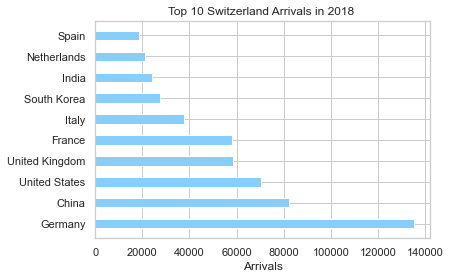

In [163]:
fig, ax = plt.subplots()

ind = np.arange(10)    # the x locations for the groups
width = 0.45       # the width of the bars


p1 = ax.barh(width/2 + ind, total_arrivals_per_country_2018['Arrivals'][:10], width, color = 'lightskyblue')#, yerr=err(median_sugar_switzerland))

ax.set_title('Top 10 Switzerland Arrivals in 2018 ')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(total_arrivals_per_country_2018['Country'][:10])

ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Top_10_Arrivals_2018.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

In the following plot is presented the monthly number of arrivals from 2018 to 2020, during the covid 19 crisis period, in Germany. It is clear that the arrivals drasticly decrease in 2020 during the months of March, April and May. Moreover, as Germany is a neighbor country of Switzerland, it highlights even more the scale of the crisis. 

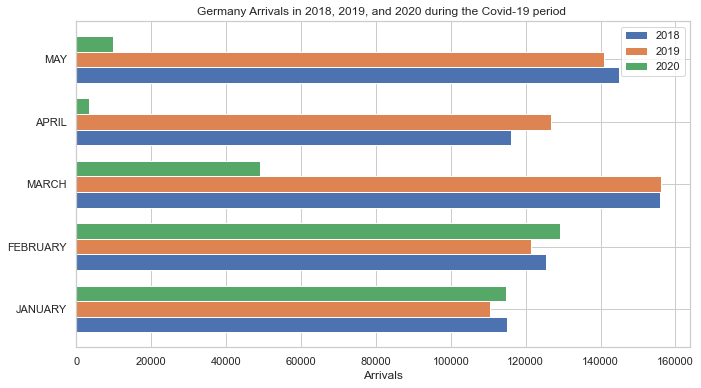

In [253]:
fig, ax = plt.subplots()

ind = np.arange(5)    # the x locations for the groups
width = 0.25       # the width of the bars


p1 = ax.barh(ind - width, corona_period_germany_2018[:5], width)
p2 = ax.barh(ind ,corona_period_germany_2019[:5], width)
p3 = ax.barh(ind + width,corona_period_germany_2020[:5], width)

ax.set_title('Germany Arrivals in 2018, 2019, and 2020 during the Covid-19 period ')
ax.set_yticks(ind)
ax.set_yticklabels(np.array(['JANUARY', 'FEBRUARY', 'MARCH', 'APRIL', 'MAY']))


ax.legend((p1[0], p2[0], p3[0]), ('2018', '2019', '2020'))
ax.autoscale_view()

plt.xlabel('Arrivals')
plt.savefig('images/Germany_Arrivals_Covid_Period.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.show()

In [166]:
# this file contains topologies for all countries in the world_map
world_map = './data/world-countries.json'
json_object = json.load(open(world_map))

## Comparison of arrivals to Switzerland by country in 2018 and during covid in 2020

To visualize more clearly the difference between year 2020 and 2018, here are two maps representing the countries of arrivals in Switzerland accross the word
We observe in these maps the contrast between the covid crisis period in 2020 and the arrivals in a 'normal' year; 2018 in that case. Indeed, asian countries are totaly absent of the 2020 map representaton.

In [167]:
for feature in json_object['features']:
    country = feature['properties']['name']
    if country not in total_arrivals_per_country_2018.Country.values:
        df =  pd.DataFrame({'Country': country, 'Arrivals': 0}, index = np.arange(1))
        total_arrivals_per_country_2018 = pd.concat([total_arrivals_per_country_2018 ,df])


In [254]:
map = folium.Map(location=[20, 0], zoom_start=2)

map.choropleth(geo_data=world_map, data=total_arrivals_per_country_2018,
             columns=['Country', 'Arrivals'],
             key_on='feature.properties.name',
             fill_color='BuGn')
map.save('map2.html')
map

/opt/anaconda3/envs/ada/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


In [169]:
for feature in json_object['features']:
    country = feature['properties']['name']
    if country not in total_arrivals_per_country_during_corona_2020.Country.values:
        df =  pd.DataFrame({'Country': country, 'Arrivals': 0}, index = np.arange(1))
        total_arrivals_per_country_during_corona_2020 = pd.concat([total_arrivals_per_country_during_corona_2020 ,df])


In [258]:
map = folium.Map(location=[20, 0], zoom_start=2)

map.choropleth(geo_data=world_map, data=total_arrivals_per_country_during_corona_2020,
             columns=['Country', 'Arrivals'],
             key_on='feature.properties.name',
             fill_color='BuGn')

map

/opt/anaconda3/envs/ada/lib/python3.8/site-packages/folium/folium.py:411: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  warnings.warn(


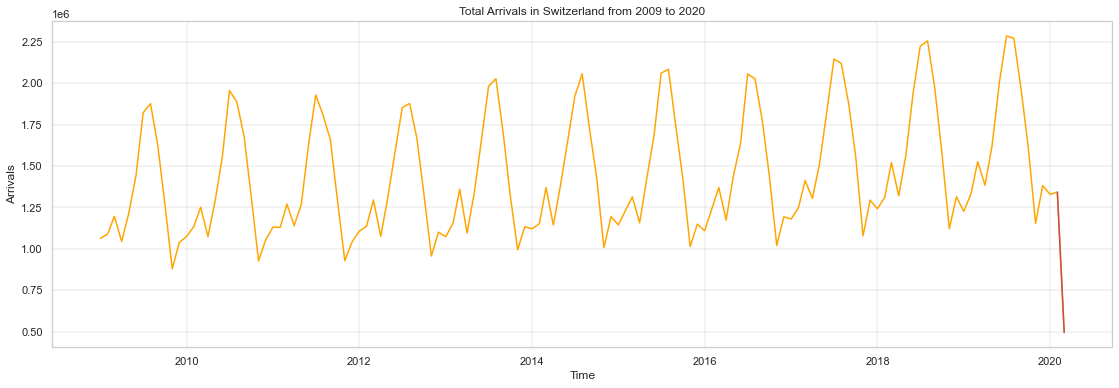

In [171]:
#Plot total number of Arrivals from Jan 2009 to March 2020 (Lockdown in Switzerland)
plt.figure(figsize= (19,6 ))
plt.plot(tourism[:datetime(2020,3,1)].index, tourism["Visitors' country of residence - total"][:datetime(2020,3,1)], color = 'orange')
plt.plot(tourism[datetime(2020,2,1):datetime(2020,3,1)].index, tourism["Visitors' country of residence - total"][datetime(2020,2,1):datetime(2020,3,1)], color = 'r')
plt.title('Total Arrivals in Switzerland from 2009 to 2020')
plt.xlabel('Time')
plt.ylabel('Arrivals')
plt.grid(color='k', linestyle='-', linewidth=0.1)
plt.show()

# III. AR Base Modelisation

Here an autoregressive model is implemeted : the data is divided into two sets : the training and the testing set. The limit is set on March 1st 2015. However, since it is an autoregressive model, it keeps on training along the prediction. Every month it uses all the previous data to improve the model by computing new coefficients for each features.

In order to chose the lages the autocorrelation coefficients of the total arrivals time serie are computed.

In [172]:
#Covid crisis for our testSet
start_date_testing = datetime(2015,3,1)
start_crisis = datetime(2020,2,1)
end_date_testing = datetime(2020,10,1)

Arrivals = pd.DataFrame(tourism["Visitors' country of residence - total"])
Arrivals.rename(columns = {"Visitors' country of residence - total": 'Total Arrivals'}, inplace = True)

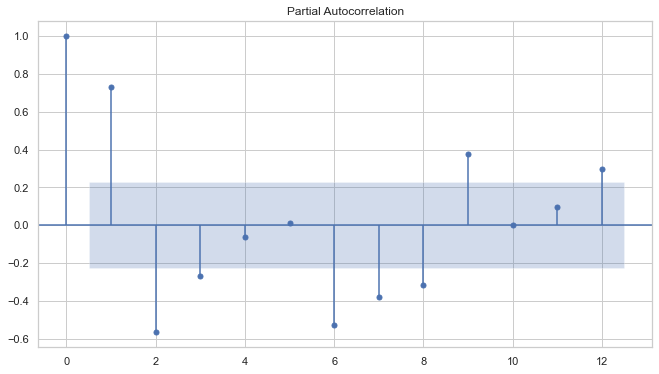

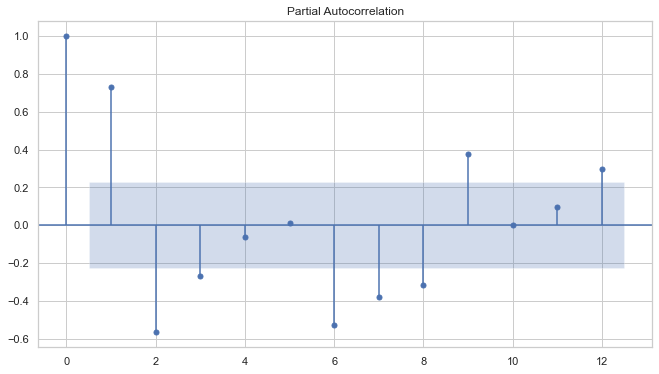

In [173]:
plot_pacf(Arrivals['Total Arrivals'][:start_date_testing], lags=12, method='ywm')

ACF is an (complete) auto-correlation function which gives values of auto-correlation of any series with its lagged values: it describes how well the present value of the series is related with its past values.


PACF is a partial auto-correlation function. Instead of finding correlations of present with lags like ACF, it finds correlation of the residuals (which remains after removing the effects which are already explained by the earlier lag(s)) with the next lag value hence ‘partial’ and not ‘complete’ as the found variations are removed the next correlation is foud. For example, if a variable Y is regressed on other variables X1, X2, and X3, the partial correlation between Y and X3 is the amount of correlation between Y and X3 that is not explained by their common correlations with X1 and X2.

Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.

A significant partial correlation are observed with variables in delays list below:

In [174]:
pacf_coeff = pacf(Arrivals['Total Arrivals'][:start_date_testing], nlags=12, method='ywm')

delays = [1,2,3,6,7,8,9,12]
lags = dict(zip(delays, (pacf_coeff[i] for i in delays)))

for lag in lags.keys() :
    Arrivals['t-'+ str(lag)] = Arrivals['Total Arrivals'].shift(lag)

Arrivals.dropna(axis=0, inplace=True)

In [175]:
Arrivals.head(4)

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0


In [176]:
#these are the testing datasets
True_Arrivals = Arrivals['Total Arrivals'][start_date_testing : end_date_testing]
True_Arrivals_until_crisis = Arrivals['Total Arrivals'][start_date_testing : start_crisis]
True_Arrivals_crisis = Arrivals['Total Arrivals'][start_crisis : end_date_testing]

In [178]:
#Trends
Hotels = pd.read_csv(FOLDER_NAME + HOTEL_FILE, header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Hotels.rename(columns = {'Hotel: (Suisse)' : 'Switzerland_Hotels_Trend'}, inplace=True)

Airbnb = pd.read_csv(FOLDER_NAME + AIRBNB_FILE, header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Airbnb.rename(columns = {'airbnb: (France)' : 'France_Airbnb_Trend'}, inplace=True)
Airbnb['France_Airbnb_Trend'] = Airbnb['France_Airbnb_Trend'].apply(lambda x : 0 if x == '<\xa01'else float(x))

Covid_19 = pd.read_csv(FOLDER_NAME + COVID19_FILE, header = 1, index_col= 'Month', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Covid_19.rename(columns = {'covid19: (Switzerland)' : 'Covid_19_France'}, inplace=True)

In [179]:
Covid_19

,Covid_19_France
Month,
2009-01-01,0
2009-02-01,0
2009-03-01,0
2009-04-01,0
2009-05-01,0
...,...
2020-08-01,22
2020-09-01,19
2020-10-01,24


In [180]:
Arrivals = pd.merge(Arrivals, Hotels, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Airbnb, right_index = True, left_index=True)
Arrivals = pd.merge(Arrivals, Covid_19, right_index = True, left_index=True)

In [181]:
Arrivals

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12,Switzerland_Hotels_Trend,France_Airbnb_Trend,Covid_19_France
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0,81,0.0,0
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0,82,0.0,0
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0,83,0.0,0
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0,80,0.0,0
2010-05-01,1287452.0,1074035.0,1251923.0,1136889.0,880617.0,1267800.0,1621888.0,1876038.0,1214666.0,84,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1342777.0,1328894.0,1381913.0,1154630.0,2270490.0,76,82.0,22
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,496239.0,1342777.0,1328894.0,1381913.0,1958831.0,72,46.0,19
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,51479.0,496239.0,1342777.0,1328894.0,1612160.0,52,37.0,24
2020-11-01,0.0,949466.0,1291992.0,1525425.0,307372.0,51479.0,496239.0,1342777.0,1154630.0,33,20.0,19


Here some trends time series are plotted:

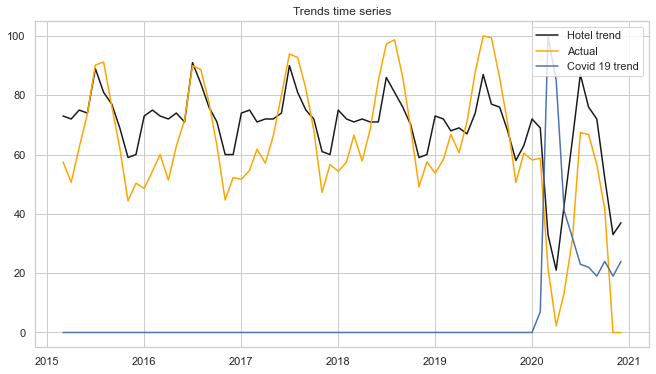

In [259]:
#Hotel plot
fig,axes = plt.subplots()
axes.plot((Arrivals[start_date_testing:]['Switzerland_Hotels_Trend']*100)/max(Arrivals['Switzerland_Hotels_Trend']), label = 'Hotel trend',color = 'k')
axes.plot((Arrivals[start_date_testing:]['Total Arrivals']*100)/max(Arrivals['Total Arrivals']), label = 'Actual',color = 'orange')
axes.plot((Arrivals[start_date_testing:]['Covid_19_France']*100)/max(Arrivals['Covid_19_France']), label = 'Covid 19 trend')
axes.set_title('Trends time series')

plt.savefig('images/Trends.png', transparent=True, bbox_inches='tight', dpi = 300)
plt.legend()

This function is implemented in order to performe a linear regression using Google trends features and lags. It retruns the predictions and the mean absolute error between the model predictions and the real hotel stays. It also prints the last computed coefficients of each feature.

In [183]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration

def Auto_Regressive_Model(True_Labels, end_date_testing, dataset, lags, trends, with_trends=False):
    
    Arrivals_Predictions = True_Labels.copy()

    if (with_trends):
        lags.extend(trends)
        
    for train_last in True_Labels.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
        
        X_train = train[lags].values
        X_test = test[lags].values
        
            
        y_train = train['Total Arrivals'].values
        y_test = test['Total Arrivals'].values
        
    
        lr = LinearRegression()
    
        lr.fit(X_train, y_train)
        
            
        if(train_last==end_date_testing):
            print('The intercept value is:', lr.intercept_ )
            for i, lag in enumerate(lags):
                print('The final estimation of {} is: {}'.format(lag, lr.coef_[i]))
        
        pred = lr.predict(X_test)
    
        Arrivals_Predictions[train_last] = pred[0]
        
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE) )
    
    return Arrivals_Predictions, MAE

From the partial autocorrelation function some lags that have a big autocorrelation coefficient are selected.
The best lags are selected for the base model (without including the Google trends). The idea is to find the best two lags in order to have a base model that fit well the true data wothout overfitting (that's why only two lags are selected). To do so, the mean absolute error (MAE) between the model predictions and the true data of all the different models (which have different lags) are compared during three periods : the testing set without the crisis (from 2015/3/1 to 2020/2/1); the crisis only (.from 2020/2/1 to 2020/10/1); the whole testing set(2015/3/1 to 2020/10/1).

Ideally this model will be further improved by adding the Google trends. 

To have an idea of how an autoregressive model behave, an AR model with only one lag is first evaluated, firstly with *t-1* and then with *t-12*. This gives an idea about the influence of these two lags.

In [184]:
lags_1 = ['t-1']
lags_2 = ['t-12']
lags_3 = ['t-1', 't-2']
lags_4 = ['t-1', 't-6']
lags_5 = ['t-1', 't-9']
lags_6 = ['t-1', 't-12']

trends = [ "Switzerland_Hotels_Trend", "Covid_19_France"]

In [185]:
MAE=pd.DataFrame({'lags':[lags_1,lags_2, lags_3, lags_4, lags_5, lags_6]})
MAE

,lags
0,[t-1]
1,[t-12]
2,"[t-1, t-2]"
3,"[t-1, t-6]"
4,"[t-1, t-9]"
5,"[t-1, t-12]"


In [186]:
_, Baseline_MAE_1= Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_2 = Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_3 = Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_3.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_4 = Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_4.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_5 = Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_5.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_6 = Auto_Regressive_Model(True_Arrivals_until_crisis, start_crisis, Arrivals,\
                                                                    lags_6.copy(),\
                                                                    trends.copy(), with_trends = False)

The intercept value is: 357229.75734148547
The final estimation of t-1 is: 0.7565300727587531
MAE :203517.7759142528
The intercept value is: 12913.89748607087
The final estimation of t-12 is: 1.0158970373331089
MAE :40502.46040795853
The intercept value is: 529623.7396738849
The final estimation of t-1 is: 1.1615089452469347
The final estimation of t-2 is: -0.5247565263596968
MAE :171485.6519284632
The intercept value is: 681366.0652085099
The final estimation of t-1 is: 0.6906440987286785
The final estimation of t-6 is: -0.15732786572719276
MAE :202208.16332132785
The intercept value is: -89464.39660998643
The final estimation of t-1 is: 0.8390479129921485
The final estimation of t-9 is: 0.2280097351332989
MAE :189245.92321444003
The intercept value is: 7713.857300728094
The final estimation of t-1 is: 0.015367058349017712
The final estimation of t-12 is: 1.0038231536165056
MAE :40771.419192476445


In [187]:
MAE['MAE from 2015/3/1 to 2020/2/1'] = [Baseline_MAE_1, Baseline_MAE_2, Baseline_MAE_3, Baseline_MAE_4, Baseline_MAE_5, Baseline_MAE_6]
MAE

,lags,MAE from 2015/3/1 to 2020/2/1
0,[t-1],203517.775914
1,[t-12],40502.460408
2,"[t-1, t-2]",171485.651928
3,"[t-1, t-6]",202208.163321
4,"[t-1, t-9]",189245.923214
5,"[t-1, t-12]",40771.419192


In [188]:
_, Baseline_MAE_1= Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_2 = Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_3 = Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_3.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_4 = Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_4.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_5 = Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_5.copy(),\
                                                                    trends.copy(), with_trends = False)
_, Baseline_MAE_6 = Auto_Regressive_Model(True_Arrivals_crisis, end_date_testing, Arrivals,\
                                                                    lags_6.copy(),\
                                                                    trends.copy(), with_trends = False)

The intercept value is: 333528.69463593117
The final estimation of t-1 is: 0.7671046465363324
MAE :338292.0053155444
The intercept value is: 191047.57435590867
The final estimation of t-12 is: 0.8529369831275062
MAE :847062.6809722371
The intercept value is: 496643.6425931449
The final estimation of t-1 is: 1.1757325776358811
The final estimation of t-2 is: -0.5250419978848885
MAE :294562.1812180218
The intercept value is: 622302.533952967
The final estimation of t-1 is: 0.7196551233546736
The final estimation of t-6 is: -0.15261791460687335
MAE :388761.3780765228
The intercept value is: 30684.527592271566
The final estimation of t-1 is: 0.8286674373096936
The final estimation of t-9 is: 0.14803677024754247
MAE :372895.81152288546
The intercept value is: -78384.15673467726
The final estimation of t-1 is: 0.4902571490218629
The final estimation of t-12 is: 0.5568713494912945
MAE :626680.0621418916


In [189]:
MAE['MAE from 2020/2/1 to 2020/10/1'] = [Baseline_MAE_1, Baseline_MAE_2, Baseline_MAE_3, Baseline_MAE_4, Baseline_MAE_5, Baseline_MAE_6]
MAE

,lags,MAE from 2015/3/1 to 2020/2/1,MAE from 2020/2/1 to 2020/10/1
0,[t-1],203517.775914,338292.005316
1,[t-12],40502.460408,847062.680972
2,"[t-1, t-2]",171485.651928,294562.181218
3,"[t-1, t-6]",202208.163321,388761.378077
4,"[t-1, t-9]",189245.923214,372895.811523
5,"[t-1, t-12]",40771.419192,626680.062142


In [190]:
Baseline_Arrivals_Predictions_1, Baseline_MAE_1= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = False)
Baseline_Arrivals_Predictions_2, Baseline_MAE_2 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_2.copy(),\
                                                                    trends.copy(), with_trends = False)
Baseline_Arrivals_Predictions_3, Baseline_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                    lags_3.copy(),\
                                                    trends.copy(), with_trends = False)
Baseline_Arrivals_Predictions_4, Baseline_MAE_4= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_4.copy(),\
                                                                    trends.copy(), with_trends = False)
Baseline_Arrivals_Predictions_5, Baseline_MAE_5= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_5.copy(),\
                                                                    trends.copy(), with_trends = False)
Baseline_Arrivals_Predictions_6, Baseline_MAE_6= Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_6.copy(),\
                                                                    trends.copy(), with_trends = False)

The intercept value is: 333528.69463593117
The final estimation of t-1 is: 0.7671046465363324
MAE :224057.2583947781
The intercept value is: 191047.57435590867
The final estimation of t-12 is: 0.8529369831275062
MAE :147492.55620377313
The intercept value is: 496643.6425931449
The final estimation of t-1 is: 1.1757325776358811
The final estimation of t-2 is: -0.5250419978848885
MAE :190220.55300474164
The intercept value is: 622302.533952967
The final estimation of t-1 is: 0.7196551233546736
The final estimation of t-6 is: -0.15261791460687335
MAE :228389.89294496918
The intercept value is: 30684.527592271566
The final estimation of t-1 is: 0.8286674373096936
The final estimation of t-9 is: 0.14803677024754247
MAE :215552.35119495585
The intercept value is: -78384.15673467726
The final estimation of t-1 is: 0.4902571490218629
The final estimation of t-12 is: 0.5568713494912945
MAE :118574.40898554429


In [191]:
MAE['MAE from 2015/3/1 to 2020/10/1'] = [Baseline_MAE_1, Baseline_MAE_2, Baseline_MAE_3, Baseline_MAE_4, Baseline_MAE_5, Baseline_MAE_6]
MAE

,lags,MAE from 2015/3/1 to 2020/2/1,MAE from 2020/2/1 to 2020/10/1,MAE from 2015/3/1 to 2020/10/1
0,[t-1],203517.775914,338292.005316,224057.258395
1,[t-12],40502.460408,847062.680972,147492.556204
2,"[t-1, t-2]",171485.651928,294562.181218,190220.553005
3,"[t-1, t-6]",202208.163321,388761.378077,228389.892945
4,"[t-1, t-9]",189245.923214,372895.811523,215552.351195
5,"[t-1, t-12]",40771.419192,626680.062142,118574.408986


The two model predictions with only one lag are firstly evaluated :

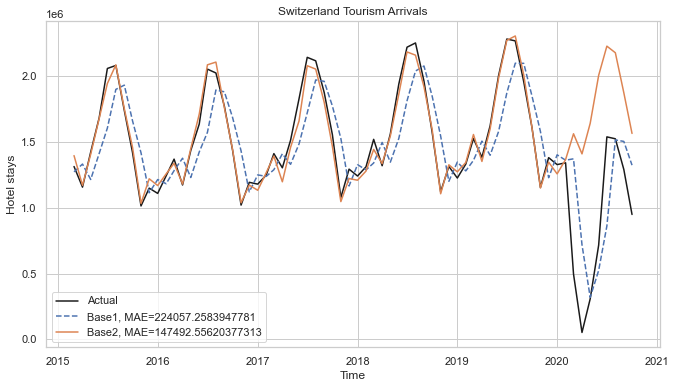

In [262]:
fig,axes = plt.subplots()

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_1, linestyle='dashed', label='Base1, MAE={}'.format(Baseline_MAE_1))
axes.plot(Baseline_Arrivals_Predictions_2, label='Base2, MAE={}'.format(Baseline_MAE_2))
plt.savefig('images/AR_pete.png', transparent=True, bbox_inches='tight', dpi = 300)

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

What one sees is that with only *t-12* the model fits very well the year pattern of the true data when there is no crisis but is completly wrong when the crisis start (MAE=33486 when normal and MAE=847062 in crisis times). On the other hand the model predictions with *t-1* does not very well normaly (MAE=220100) but is much better during the crisis (MAE=338292).

The other different models predictions are now plotted:

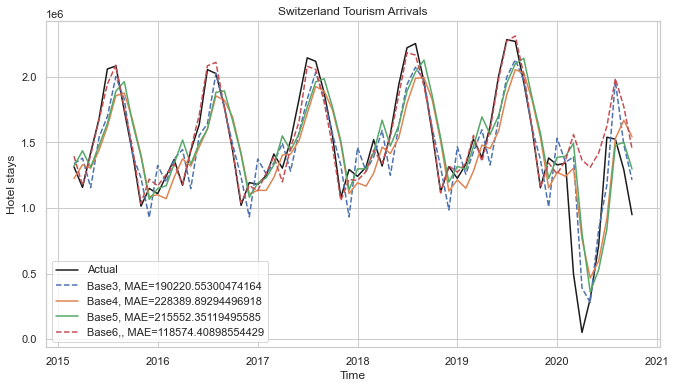

In [263]:
fig,axes = plt.subplots()

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_3, linestyle='dashed', label='Base3, MAE={}'.format(Baseline_MAE_3))
axes.plot(Baseline_Arrivals_Predictions_4, label='Base4, MAE={}'.format(Baseline_MAE_4))
axes.plot(Baseline_Arrivals_Predictions_5, label='Base5, MAE={}'.format(Baseline_MAE_5))
axes.plot(Baseline_Arrivals_Predictions_6, linestyle='dashed', label='Base6,, MAE={}'.format(Baseline_MAE_6))
plt.savefig('images/AR.png', transparent=True, bbox_inches='tight', dpi = 300)

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

The best two models are those using lags *t-1, t-2* and *t-1, t-9*. 

they will now be improved with Google trends. Here one didn't selected these trend labels with any algorithm, this will be the object of the rest of this script, one simply chose these labels thinking they could help improve the two models.

Once again the model using only the lag *t-1* is studied to have an idea of the improvement done by the Google trends.

In [194]:
Trends_Arrivals_Predictions_1, Trend_MAE_1 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_1.copy(),\
                                                                    trends.copy(), with_trends = True)

The intercept value is: -634903.063888158
The final estimation of t-1 is: 0.5510373666271741
The final estimation of Switzerland_Hotels_Trend is: 17418.52692849908
The final estimation of Covid_19_France is: -143.29676933840636
MAE :180427.17786433984


In [195]:
Trends_Arrivals_Predictions_3, Trend_MAE_3 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_3.copy(),\
                                                                    trends.copy(), with_trends = True)

The intercept value is: -323321.48626017757
The final estimation of t-1 is: 0.7312998448510744
The final estimation of t-2 is: -0.18464128079663322
The final estimation of Switzerland_Hotels_Trend is: 13290.721785675983
The final estimation of Covid_19_France is: -1628.8206814294485
MAE :181169.7723580981


In [196]:
Trends_Arrivals_Predictions_5, Trend_MAE_5 = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals,\
                                                                    lags_5.copy(),\
                                                                    trends.copy(), with_trends = True)

The intercept value is: -1043074.817077504
The final estimation of t-1 is: 0.6271936744192801
The final estimation of t-9 is: 0.20731529440110832
The final estimation of Switzerland_Hotels_Trend is: 17432.129316652445
The final estimation of Covid_19_France is: -1169.6399842378387
MAE :165490.2234141291


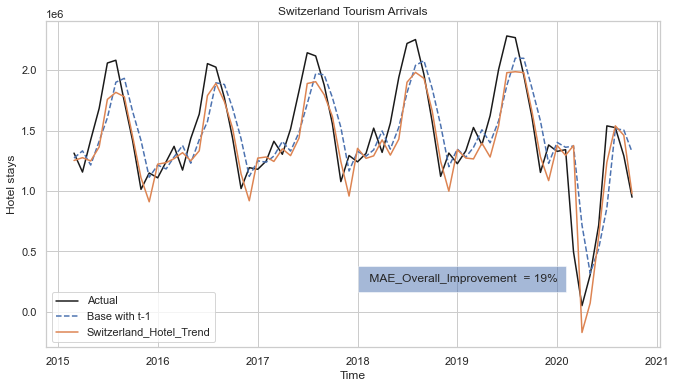

In [264]:
fig,axes = plt.subplots()

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_1, linestyle='dashed', label='Base with t-1')
axes.plot(Trends_Arrivals_Predictions_1, label='Switzerland_Hotel_Trend')


plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format( int(100 * np.abs(Trend_MAE_1-Baseline_MAE_1)/Baseline_MAE_1)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

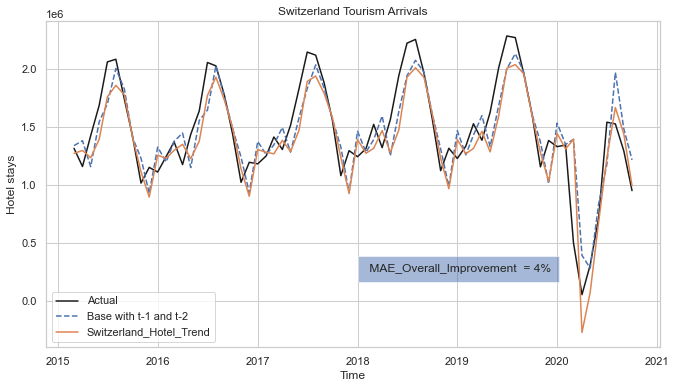

In [266]:
fig,axes = plt.subplots()

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_3, linestyle='dashed', label='Base with t-1 and t-2')
axes.plot(Trends_Arrivals_Predictions_3, label='Switzerland_Hotel_Trend')

plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(Trend_MAE_3-Baseline_MAE_3)/Baseline_MAE_3)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

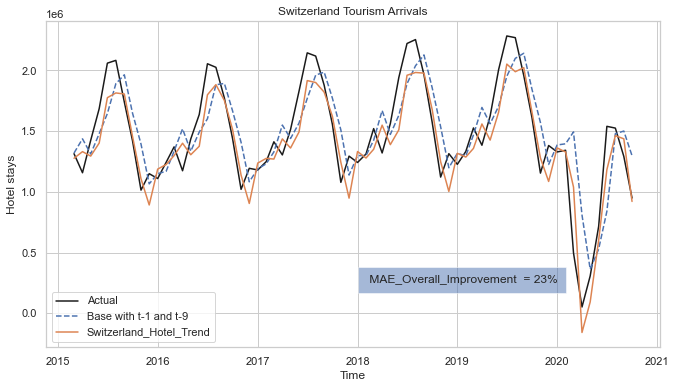

In [267]:
fig,axes = plt.subplots()

axes.plot(Arrivals['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(Baseline_Arrivals_Predictions_5, linestyle='dashed', label='Base with t-1 and t-9')
axes.plot(Trends_Arrivals_Predictions_5, label='Switzerland_Hotel_Trend')
plt.savefig('images/improvment.png', transparent=True, bbox_inches='tight', dpi = 300)

plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(Trend_MAE_5-Baseline_MAE_5)/Baseline_MAE_5)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

As one can see, the model using *t-1* and *t-9* is really improved using the two Google trend labels given previously. One will therefore use this model as a base model in the rest of this script.

In [205]:
base_model_prediction = Baseline_Arrivals_Predictions_5
Baseline_MAE = Baseline_MAE_5

# IV.  Feature engineering : Choosing Trends Keywords

In order to choose the Trends to help the base model predict hotel stays. We propose two different perspectives. Those two perspectives will offer a wide choice of possible trends and in the next part, a method will choose from those proposed trends.

The first perspective consists of webscraping websites linked to tourism in Switzerland while the second perspective is keywords were chosen related to the topic.

## Parsing text from website to find related topics 

Several website linked to tourism in Switzerland were scraped from the web. Text processing will be performed in order to identify topics commonly found in those websites. Those topics might form intersting keywords worth tested as features in the linear regression. Tokenization technics will be used.

### a. Text processing to get the most common keywords

Open the data.txt where the tourism articles has been concatenated:

In [206]:
f = open(FOLDER_NAME + ARTICLE, "r")
data = f.read()
f.close()

Some useful functions:

In [207]:
def remove_punctuation(text):
    no_punct=[words for words in text if words not in string.punctuation]
    words_wo_punct=''.join(no_punct)
    return words_wo_punct

def tokenize(text):
    split=re.split("\W+",text) 
    return split

def count_words(text):
    for word in text:
        word_count[word]+=1
    return None

stopword = nltk.corpus.stopwords.words('english')
ps = PorterStemmer()
def remove_stopwords_plus_stem(text):
    text=[ps.stem(word) for word in text if word not in stopword]
    return text

The punctuations are removed and the data is splited by lines:

In [210]:
df = pd.DataFrame([remove_punctuation(line) for line in data.split("\n") if line])
df.columns = ["lines"]
df['lines']=df['lines'].apply(lambda x: tokenize(x.lower()))

Stopwords are removed (i.e. uninteresting words). Moreover, words are simplified to their roots :

In [211]:
df['lines'] = df['lines'].apply(lambda x: remove_stopwords_plus_stem(x))

word_count = defaultdict(int)

df["lines"].apply(lambda x: count_words(x))
word_count = {k: v for k, v in sorted(word_count.items(), key=lambda item: item[1], reverse=True)}
word_count_df = pd.DataFrame(word_count, index=["count"]).transpose().head(50)
word_count_df.head(18)

,count
switzerland,945
,816
swiss,382
travel,370
hotel,340
one,268
visit,263
best,242
lake,235
price,207


This list corresponds to the most common words in the touristic websites database.

## b. Choose a keyword list and get the translations

We instantiate a class that allows us to communicate with google translator's API:

In [212]:
translator = google_translator()

We choose a list of keywords in english:

In [213]:
kw_list = ["swiss " + word for word in list(word_count_df.index[2:20])]
kw_list = ["Hotel Switzerland","travel Switzerland", "Visit Switzerland", "lake Switzerland", "Geneva"]
kw_list = ["Vacation Switzerland","Flight Geneva", "price Switzerland", "Airbnb switzerland", "flight zurich"]

We create a dictionnary of countries with its respective most spoken language:

In [214]:
language_list = ["en","fr","de","ja","de"]
lang_dict = {
    "US": "en",
    "FR": "fr",
    "DE": "de",
    "JP": "ja",
    "CH": "de"
}

We create a dictionnary of lists of keywords translated in each language of interest:

In [215]:
kw_dict = {}
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    kw_list_coutry = []
    for kw in kw_list:
        kw_list_coutry.append( translator.translate(kw,lang_tgt=lang_dict[country]) )
    kw_dict[country] = kw_list_coutry
    print(kw_dict[country])

['Vacation Switzerland ', 'Flight Geneva ', 'price Switzerland ', 'Airbnb switzerland ', 'flight zurich ']
['Vacances en Suisse ', 'Vol Genève ', 'prix Suisse ', 'Airbnb Suisse ', 'vol zurich ']
['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich ']
['休暇スイス ', 'ジュネーブ便 ', '価格スイス ', 'Airbnbスイス ', 'フライトチューリッヒ ']
['Urlaub Schweiz ', 'Flug Genf ', 'Preis Schweiz ', 'Airbnb Schweiz ', 'Flug Zürich ']


## c. Get and plot the Trends Time series

This shows how we get the google trends time series by language and country, and how we get the language and country parameter in our automated process :

In [216]:
#This is the how we get the google trends time series by language 
#and country.
pytrends = TrendReq(hl="en-US", tz=360)

#So this is how we get the language and country parameter in our
#automated process.
countries = ["US", "FR", "DE", "JP", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    print(lc)

en-US
fr-FR
de-DE
ja-JP
de-CH


Here is a dataframe with the Goodle trends time series by country with its respective most spoken language :

In [217]:
dfs = {}
countries = ["US", "FR", "DE", "CH"]
for country in countries:
    lc=lang_dict[country]+"-"+country
    pytrends = TrendReq(hl=lc, tz=360)
    pytrends.build_payload(kw_dict[country], cat=0, timeframe='all', geo=country, gprop='')
    dfs[country] = pytrends.interest_over_time()

In [218]:
dfs

{'US':             Vacation Switzerland   Flight Geneva   price Switzerland   \
 date                                                                    
 2004-01-01                      0               0                   0   
 2004-02-01                     57               0                  29   
 2004-03-01                     36               0                   0   
 2004-04-01                     28               0                   0   
 2004-05-01                     26               0                   0   
 ...                           ...             ...                 ...   
 2020-08-01                     13               6                  11   
 2020-09-01                     11               4                  18   
 2020-10-01                      9               7                  17   
 2020-11-01                      8               4                  18   
 2020-12-01                      7               7                   7   
 
             Airbnb switzerlan

We split the dict into dataframes containing the sum of these Google trends of each contry separately :

### Summing trends from different regions and languages into one

Here, the data for the words from webscraping are summed over languages and regions. Each word, was searched in different languages for each correspondig country. Then it was summed into simple features.

For example, the word 'Flight Geneva' was searched in english in the US, in german in Germany, in French in France, etc.. Later, those features from different region are compacted into simple features for each word.

This let us use the appropriate language in each country that was parsed. The country chosen are the ones where most of swiss visiters come from (US, France, Germany and Switzerland). German was used for Switzerland.

In [219]:
US = dfs["US"].drop(columns="isPartial").sum(axis='columns')
FR = dfs["FR"].drop(columns="isPartial").sum(axis='columns')
DE = dfs["DE"].drop(columns="isPartial").sum(axis='columns')
CH = dfs["CH"].drop(columns="isPartial").sum(axis='columns')

US = pd.DataFrame(data=US).rename(columns = {0:'US'})
FR = pd.DataFrame(data=FR).rename(columns = {0:'FR'})
DE = pd.DataFrame(data=DE).rename(columns = {0:'DE'})
CH = pd.DataFrame(data=CH).rename(columns = {0:'CH'})

df_summed = US.join([FR, DE, CH])
WORLD = pd.DataFrame(df_summed.sum(axis='columns')).rename(columns = {0:'WORLD'})

Here one plots some time series:

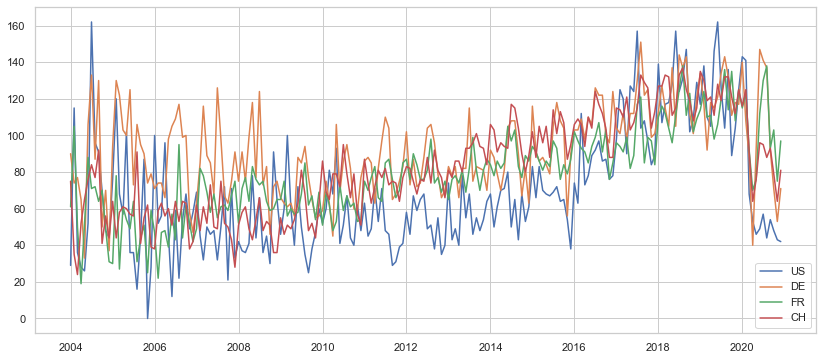

In [221]:
fig = plt.figure(figsize=(14,6))
plt.plot(US.index[-1000:], US[-1000:], label='US')
plt.plot(DE.index[-1000:], DE[-1000:], label='DE')
plt.plot(FR.index[-1000:], FR[-1000:], label='FR')
plt.plot(CH.index[-1000:], CH[-1000:], label='CH')
#plt.plot(dfs["JP"].index[-196:], dfs["JP"][kw_dict["JP"][a]][-196:], label='JP')

plt.legend()
plt.show()
#plt.plot(dfs["DE"]["swiss mountain"])

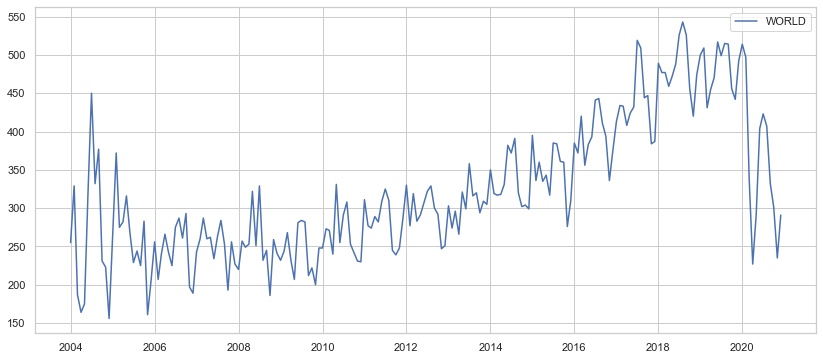

In [222]:
fig = plt.figure(figsize=(14,6))
plt.plot(WORLD.index[-1000:], WORLD[-1000:], label='WORLD')
plt.legend()
plt.show()

One can see that at the begining of the crisis, the Google queries fall significantly.

### Importing trends from topic-analysis
one selects the top 10 words from topic analysis of webscraping (without the three first ones).

In [225]:
# Recuperer les trends

def import_trends(trends_list):
    df = {}
    #print(trends_list)
    
    lc="en-US"
    pytrends = TrendReq(hl=lc, tz=360)
    pytrends.build_payload(trends_list, cat=0, timeframe='all', gprop='')
    print(pytrends.interest_over_time())
    df = pytrends.interest_over_time()  
    df = df.drop(columns='isPartial')
    #print( df[trend])
    return df


In [226]:
def import_and_merges(trends_list,to_be_merge_to):
    trends_content = import_trends(trends_list)    
    to_be_merge_to = pd.merge(to_be_merge_to, trends_content, right_index = True, left_index=True)      
    return to_be_merge_to

In [234]:
topics_trends = ["swiss " + word for word in list(word_count_df.index[3:13])]
topics_trends

['swiss travel',
 'swiss hotel',
 'swiss one',
 'swiss visit',
 'swiss best',
 'swiss lake',
 'swiss price',
 'swiss view',
 'swiss get',
 'swiss mountain']

In [235]:
topics_trends1 = topics_trends[0:4]
topics_trends2 = topics_trends[4:8]
topics_trends3 = topics_trends[8:11]
Arrivals_lags_features = Arrivals
Arrivals_lags_features = import_and_merges(topics_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(topics_trends2,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(topics_trends3,Arrivals_lags_features)

            swiss travel  swiss hotel  swiss one  swiss visit isPartial
date                                                                   
2004-01-01            21           75          8            4     False
2004-02-01            19           69          0            0     False
2004-03-01            17           71          2            2     False
2004-04-01            32           76          4            0     False
2004-05-01            21          100          6            2     False
...                  ...          ...        ...          ...       ...
2020-08-01             4           23          5            0     False
2020-09-01             4           21          5            1     False
2020-10-01             3           19          6            0     False
2020-11-01             3           17          5            0     False
2020-12-01             3           20          5            0      True

[204 rows x 5 columns]
            swiss best  swiss lake  swis

## Proposing other Trends keywords

Some keywords can be expected to serve as indicators of hotel booking. For example 'Hotel Switzerland' or 'flight to switzerland'. All holidays-related words might not give a good correlation since poeple probably kept on searching for holiday destinations during the corona crisis. We will thus focus our effort to keywords implying holiday's logistic (like flights and accomodations). People will book an hotel only when they are sure of travelling.

A list of keywords that might be related to hotel reservations is proposed. The correlation is tested to find the best keywords to use in our model. For the sake of simplicity, we will try to limit ourselves to 5 keywords.

Suggested keywords : 'Holidays Switerland', 'Hotel Switzerland', 'Flight Switzerland', 'travel visa Switzerland', 'Geneva Airport', 'Zurich Airport', 'Visit Switzerland', 'Hike Switzerland', 'Visit Geneva', 'Visit Lucerne', 'Visit Zurich', 'Visit Lausanne', 'Ski in Switzerland', 'Skipass Zermatt', 'Airbnb Switzerland'

In addition to keywords, the categorising feature of Google Trends is going to be used for the categories 'Travel/Hotel&Accomodation', 'Travel/Touristic Destination/Ski Resort' and 'Travel/Touristic Destination/Switzerland'

Other keywords related to the COVID-19 crisis are added such as : 'Quarantine Switzerland', 'COVID 19 switzerland', 'covid restrictions Switzerland', 'travel restrictions switzerland', 'covid-19', 'Test covid switzerland'

The COVID-related words must be categorised differently than Hotel-related words. Indeed, those could not have been predicted before the emmergence of the COVID crisi and thus it would not have made sense to build a model using them one year ago. However, since the crisis is now aknowledged, they can be used in order to predict the future of the crisis. After all, the goal of this model is to predict the present. allow ourselves to use those present informations to improve the model. We will use both features and they will be reffered to as 'Hotel-Trends' and 'Hotel+COVID-Trends'.

### Importing suggested trends 

In [236]:
suggested_trends = ['Holidays Switerland', 'Hotel Switzerland', 'Flight Switzerland', 'travel visa Switzerland', 'Geneva Airport', 'Zurich Airport', 'Visit Switzerland', 'Hike Switzerland', 'Visit Geneva', 'Visit Lucerne', 'Visit Zurich', 'Visit Lausanne', 'Ski in Switzerland', 'Skipass Zermatt', 'Airbnb Switzerland','Hotel','Flight']
suggested_trends1 = suggested_trends[0:4]
suggested_trends2 = suggested_trends[4:8]
suggested_trends3 = suggested_trends[8:13]
suggested_trends4 = suggested_trends[13:18]

covid_trends = ['Quarantine Switzerland',  'covid restrictions Switzerland', 'travel restrictions switzerland', 'covid19', 'Test covid']
covid_trends1 = covid_trends[0:4]
covid_trends2 = covid_trends[4:8]

In [237]:
Arrivals_lags_features = import_and_merges(suggested_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends2,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends3,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(suggested_trends4,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(covid_trends1,Arrivals_lags_features)
Arrivals_lags_features = import_and_merges(covid_trends2,Arrivals_lags_features)

            Holidays Switerland  Hotel Switzerland  Flight Switzerland  \
date                                                                     
2004-01-01                    0                 75                   4   
2004-02-01                    0                 80                  21   
2004-03-01                    0                 67                   0   
2004-04-01                    0                 49                   4   
2004-05-01                    0                 83                   7   
...                         ...                ...                 ...   
2020-08-01                    0                 85                   8   
2020-09-01                    0                 72                   8   
2020-10-01                    0                 75                   8   
2020-11-01                    0                 22                   7   
2020-12-01                    0                 16                   8   

            travel visa Switzerland i

### Importing category trends

We include trends from the category feature of google trends


In [238]:
category_trends = ['Travel_HotelAccomodation', 'Travel_TouristicDestination_SkiResort' , 'Travel_TouristicDestination_Switzerland']

#reading csv's
Travel_HotelAccomodation = pd.read_csv('Data/Trends/Travel_HotelAccomodation.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Travel_TouristicDestination_SkiResort = pd.read_csv('Data/Trends/Travel_TouristicDestination_SkiResort.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))
Travel_TouristicDestination_Switzerland = pd.read_csv('Data/Trends/Travel_TouristicDestination_Switzerland.csv', header = 1, index_col= 'Mois', parse_dates=[0], date_parser = lambda x : datetime.strptime(x, '%Y-%m'))

#renaming the columns
Travel_HotelAccomodation = Travel_HotelAccomodation.rename(columns = {'Geo: Suisse' : 'Travel_HotelAccomodation'})
Travel_TouristicDestination_SkiResort = Travel_TouristicDestination_SkiResort.rename(columns = {'Geo: Suisse' : 'Travel_TouristicDestination_SkiResort'})
Travel_TouristicDestination_Switzerland = Travel_TouristicDestination_Switzerland.rename(columns = {'Geo: Suisse' : 'Travel_TouristicDestination_Switzerland'})

#merging with the main df
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_HotelAccomodation, right_index = True, left_index=True)
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_TouristicDestination_SkiResort, right_index = True, left_index=True)
Arrivals_lags_features = pd.merge(Arrivals_lags_features, Travel_TouristicDestination_Switzerland, right_index = True, left_index=True)

#does it work ?
Arrivals_lags_features

,Total Arrivals,t-1,t-2,t-3,t-6,t-7,t-8,t-9,t-12,Switzerland_Hotels_Trend,...,Hotel,Flight,Quarantine Switzerland,covid restrictions Switzerland,travel restrictions switzerland,covid19,Test covid,Travel_HotelAccomodation,Travel_TouristicDestination_SkiResort,Travel_TouristicDestination_Switzerland
2010-01-01,1075731.0,1039895.0,880617.0,1267800.0,1821751.0,1446249.0,1214666.0,1045137.0,1064111.0,81,...,63,8,0,0,0,0,0,35,55,48
2010-02-01,1136889.0,1075731.0,1039895.0,880617.0,1876038.0,1821751.0,1446249.0,1214666.0,1089483.0,82,...,63,7,0,0,0,0,0,36,49,46
2010-03-01,1251923.0,1136889.0,1075731.0,1039895.0,1621888.0,1876038.0,1821751.0,1446249.0,1196859.0,83,...,63,7,0,0,0,0,0,39,39,44
2010-04-01,1074035.0,1251923.0,1136889.0,1075731.0,1267800.0,1621888.0,1876038.0,1821751.0,1045137.0,80,...,62,8,0,0,0,0,0,36,33,42
2010-05-01,1287452.0,1074035.0,1251923.0,1136889.0,880617.0,1267800.0,1621888.0,1876038.0,1214666.0,84,...,62,8,0,0,0,0,0,37,33,45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,1525425.0,1539928.0,716421.0,307372.0,1342777.0,1328894.0,1381913.0,1154630.0,2270490.0,76,...,46,7,0,0,0,17,59,26,54,55
2020-09-01,1291992.0,1525425.0,1539928.0,716421.0,496239.0,1342777.0,1328894.0,1381913.0,1958831.0,72,...,38,6,0,0,0,13,76,23,48,48
2020-10-01,949466.0,1291992.0,1525425.0,1539928.0,51479.0,496239.0,1342777.0,1328894.0,1612160.0,52,...,36,6,0,0,0,12,82,19,45,43
2020-11-01,0.0,949466.0,1291992.0,1525425.0,307372.0,51479.0,496239.0,1342777.0,1154630.0,33,...,28,6,0,0,0,11,92,14,37,35


# V. Modeling : Using trends

In the previous part, we suggest many (more than 30) candidates for features (from Trends). We will now focus on building a model that uses them in an efficient way. The number of used trends has to be limited to few. We will show how we are going to choose the best ones.

Before that, let us redefine the function for autoregression modelling. It is very simillar to the previous one. However, it now delivers a FataFrame that contains the information (coefficient, feature and p-value) for each feature (lag or Trends). 

### We redefine our regression function a bit differently to include p-values

In [239]:
#Implementation of the Linear Regression model with or without the Google Trends features, with a training window increasing at every iteration


def Auto_Regressive_Model(True_Labels, end_date_testing, dataset, lags, trends, with_trends=False):
    
    Arrivals_Predictions = True_Labels.copy()

    if (with_trends):
        lags.extend(trends)
        
    for train_last in True_Arrivals.index:
        train = dataset[ :train_last -timedelta(days=1)]
        test = dataset[train_last : end_date_testing]
        
        X_train = train[lags].values
        X_test = test[lags].values
        
        y_train = train['Total Arrivals'].values
        y_test = test['Total Arrivals'].values
    
        lm = LinearRegression()
        lm.fit(X_train,y_train)
       
        predictions = lm.predict(X_test)    
        Arrivals_Predictions[train_last] = predictions[0]
    
        if(train_last==end_date_testing):
            X = X_train
            y = y_train

            X2 = sm.add_constant(X)
            est = sm.OLS(y, X2)
            est2 = est.fit()
            #print(est2.summary())
            pvals = est2.pvalues
            coeff = est2.params
            features = np.append('intercept',lags)
            
            feature_eval = pd.DataFrame({"features":features,
                                  "coefficient":coeff,
                                  "p value":pvals, })
    
           
  
    MAE = mean_absolute_error(True_Labels, Arrivals_Predictions)
    print("MAE :{}".format(MAE))
        
    return Arrivals_Predictions, MAE, feature_eval

The new function is tested here :

In [240]:
trends = category_trends
lags = ['t-1','t-9']

Arrival_prediction_Hotel_test, MAE_Arrival_prediction_Hotel_test, table = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    trends.copy(), with_trends = True)

table

MAE :179564.86746137557


,features,coefficient,p value
0,intercept,-670260.518513,6.724098e-03
1,t-1,0.587614,1.160190e-11
2,t-9,-0.015837,8.524973e-01
3,Travel_HotelAccomodation,-6441.103211,2.044403e-01
4,Travel_TouristicDestination_SkiResort,-10254.304949,4.779073e-02
5,Travel_TouristicDestination_Switzerland,42264.094874,2.068946e-07


This table will be used to choose the best Trends keywoards as feature for our model in the next step.

### Function selecting the best features :

We consider that a feature is good (i.e. worth using in our model) if it has a low p-value. Indeed, a low p-value means that it as low chances to happen under the null hypothesis. Here, the null Hypothesis would be "the Trends data is not an indicator of the number of hotel nights sold".

Thus, the features (without the lags) are sorted by p-values and the top is selected to give the best features. To sum up, we do a first linear regression with all the features. Then, only the top ones are selected and used to do another linear regression.

In [242]:
def chooses_best_features(sum_up_table, top_how_many, lags):
       
    sum_up_table=sum_up_table[1+len(lags):]
    sum_up_table=sum_up_table.sort_values(by=['p value'])
    #print(sum_up_table)
    best_features = sum_up_table[0:top_how_many]['features']
    
    return best_features

In [243]:
best = chooses_best_features(table,2,lags)
best

5    Travel_TouristicDestination_Switzerland
4      Travel_TouristicDestination_SkiResort
Name: features, dtype: object

The function is tested and works ! Let's move on to actual computing.

# VI. Results

## First Scenario : Results with hotel-related trends

In this scenario, we build a long-term model that uses all the hotel-realted trends (from web-scraping, categories and suggested keywords). This model could have been done long ago, without the knowledge of the coming corona crisis. Indeed it is tailored to fit any crisis. The hotel-related trends might give the algorithm more dynamics and more information in order to beat the base model.

The three best trends are selected by the algorithm and are given below.

In [245]:
trends = category_trends+topics_trends+suggested_trends
lags = ['t-1','t-9']


#Makes a model with all the features
Arrival_prediction_Hotel_Trends, MAE_Hotel_Trends, Table_Hotel_Trends = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    trends.copy(), with_trends = True)
#Table_Hotel_Trends

#selects the features with the lowest p-value
best_features_hotel = chooses_best_features(Table_Hotel_Trends,3,lags)
print('The selected Trends are :')
trends = best_features_hotel
trends


MAE :150880.22873666364
The selected Trends are :


31                                      Hotel
5     Travel_TouristicDestination_Switzerland
28                         Ski in Switzerland
Name: features, dtype: object

### Interpreting the selected Trends
The keywords selected by the algorithm are close from the subject and could give valuable information on hotel night sales. This leads us to think that the algorithm works properly.

The first keyword 'Hotel' seems obvious and is from suggested keywords. The second one corresponds to the category 'Travel/TouristicDestination/Switzerland'. It fits exactly our goal. The fact that it is selected by the algorithm means that it is a valuable feature. Thus, that makes sense that the paper "predicting the present" uses mainly categories from Trends (instead of keywords).

The next step is to simulate the model using those three trends (in addition to the two lags from the base model t-1 and t-9) and to plot it.

MAE :165701.4771681781


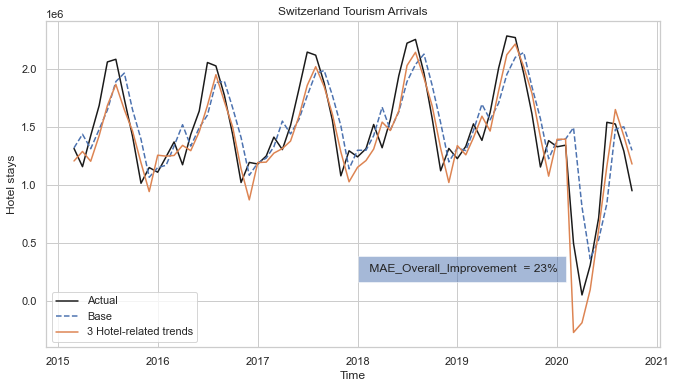

In [269]:
#Simulates with the selected features
Arrival_prediction_Hotel_Trends, MAE_Hotel_Trends, Table_Hotel_Trends = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    trends.copy(), with_trends = True)

#plot it!
fig,axes = plt.subplots()

axes.plot(Arrivals_lags_features['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(base_model_prediction, linestyle='dashed', label='Base')
axes.plot(Arrival_prediction_Hotel_Trends, label='3 Hotel-related trends')
plt.savefig('images/Best_model.png', transparent=True, bbox_inches='tight', dpi = 300)

plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(MAE_Hotel_Trends-Baseline_MAE)/Baseline_MAE)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('Hotel stays')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

### Interpreting the result

The model using trends fits the real hotel nights more closely than the base model all along the testing set (from 2015 to today). The improvement can be seen easily and is even mor spectular during the coivd crisis (all along 2020). This impression is confirmend by the MAE computation. Indeed, taking hotel-related Trends in consideration improves the MAE by 26%.

## Second Scenario : Results with covid-related trends and hotel-related trends

The second scenario is more specific to the covid situation. This second model could have been implemented only after the beginning of the corona crisis. Indeed, trends related to covid-19 are used in complement to the hotel related trends. In the previous scenario, the most significative features is selected with a function. The same function is used to select the most important covid-related trend among the list of proposed ones. 

In [248]:
trends = covid_trends
lags = ['t-1', 't-9']

#Makes a model with all the features
Arrival_prediction_covid_Trends, MAE_covid_Trends, Table_covid_Trends = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                   lags.copy(),\
                                                                   trends.copy(), with_trends = True)
Table_covid_Trends

MAE :209028.90016314058


,features,coefficient,p value
0,intercept,-1.199075e+04,9.371018e-01
1,t-1,7.912188e-01,6.429856e-26
2,t-9,2.231690e-01,8.086061e-04
3,Quarantine Switzerland,-2.153741e-12,6.756999e-07
4,covid restrictions Switzerland,0.000000e+00,NaN
5,travel restrictions switzerland,0.000000e+00,NaN
6,covid19,-9.678525e+03,5.098266e-07
7,Test covid,4.940479e+03,2.186555e-02


In [249]:
#selects the features with the lowest p-value
best_features_covid = chooses_best_features(Table_covid_Trends,1,lags)
print('The 3 selected covid Trends are :')
best_features_covid.index = np.arange(len(best_features_covid))
best_features_covid

The 3 selected covid Trends are :


0    covid19
Name: features, dtype: object

The most siginificative trend keyword is simply covid19. Its interest over time is ploted in the following figure. The emmergence of covid in the beginning of 2020 creates a violent spike in the interest overtime, going from minimum to maximum in the span of two months.

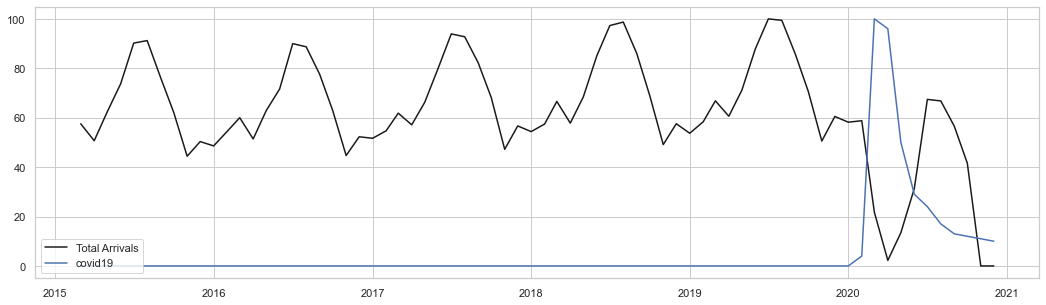

In [250]:
#covid plot
fig,axes = plt.subplots(figsize=(18,5))
axes.plot((Arrivals[start_date_testing:] ['Total Arrivals']*100)/max(Arrivals[start_date_testing:]['Total Arrivals']), label = 'Total Arrivals',color = 'k')
for i in range(len(best_features_covid)):
    axes.plot((Arrivals_lags_features[start_date_testing:][best_features_covid[i]]*100)/max(Arrivals_lags_features[best_features_covid[i]]), label = best_features_covid[i])

plt.legend(loc = 'lower left')

Thus, the trends used are :

In [251]:
#we use the 8 best hotel trends and 3 best covid trends
trends = np.append(best_features_hotel,best_features_covid)
trends

array(['Hotel', 'Travel_TouristicDestination_Switzerland',
       'Ski in Switzerland', 'covid19'], dtype=object)

The new simulation is made with this trends and lags t-1 and t-9

MAE :165701.4771681781


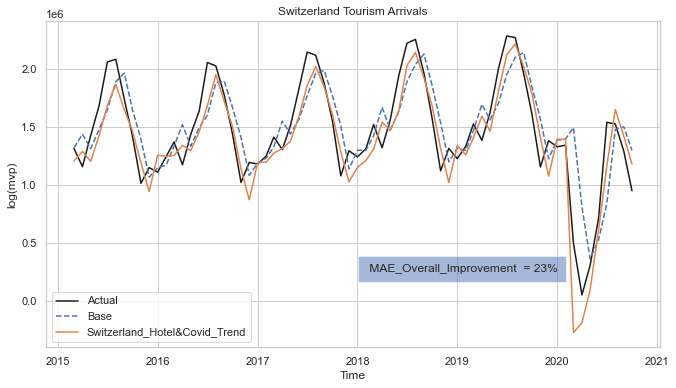

In [270]:
#Simulates with the selected features
#end_date_testing = datetime()
Arrival_prediction_covid_Trends, MAE_covid_Trends, Table_covid_Trends = Auto_Regressive_Model(True_Arrivals, end_date_testing, Arrivals_lags_features,\
                                                                    lags.copy(),\
                                                                    trends.copy(), with_trends = True)

#plot it!
fig,axes = plt.subplots()

axes.plot(Arrivals_lags_features['Total Arrivals'][start_date_testing:end_date_testing], label = 'Actual',color = 'k')
axes.plot(base_model_prediction, linestyle='dashed', label='Base')
axes.plot(Arrival_prediction_covid_Trends, label='Switzerland_Hotel&Covid_Trend')
plt.savefig('images/covid_model.png', transparent=True, bbox_inches='tight', dpi = 300)

plt.text('2018-02-01', 0.25*1e6, ' MAE_Overall_Improvement  = {}%'.format(int(100 * np.abs(MAE_covid_Trends-Baseline_MAE)/Baseline_MAE)), bbox={ 'alpha':0.5, 'pad':8})

plt.xlabel('Time')
plt.ylabel('log(mvp)')
plt.title('Switzerland Tourism Arrivals')
plt.legend()

### Interpreting the results

Those trends help to improve the BaseModel. However, the overall improvement is only 23% which is less than without using covid-related trends. This result could be explained by two factors :
- The spike of the covid trend is too violent for the linear regression to compute. Instead of being a latent tendency, it looks more like a sudden spike of interest.
- There is not enough data and historic about covid to compute precise coefficinets even thoug there is a clear correlation between covid and the drop of hotel stays caused by the covid crisi in Switzerland.